In [3]:
library(harmony)
library(tidyverse)
library(data.table)
source('utils.R')
source('melody.R')

In [2]:
# devtools::install_git('/PHShome/ik936/tmp/harmony')

# Correction function


    variable read depth
    batch effect

In [3]:
# library(SingleCellExperiment)
# library(DropletUtils)

## Get cell lines data (small)

In [4]:
exprs_raw <- Reduce(cbind, list(
    read10x('/data/srlab/ik936/Foxxy/data/jurkat/293t/hg19/', 't293'),
    read10x('/data/srlab/ik936/Foxxy/data/jurkat/jurkat/hg19/', 'jurkat'),
    read10x('/data/srlab/ik936/Foxxy/data/jurkat/fifty_fifty/hg19/', 'half')
))


In [5]:
meta_raw <- data.table(cell_id = colnames(exprs_raw))
meta_raw$nUMI <- Matrix::colSums(exprs_raw)
meta_raw$nGene <- Matrix::colSums(exprs_raw > 0)
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_raw$percent_mito <- Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)

head(meta_raw)

cell_id,nUMI,nGene,percent_mito
<chr>,<dbl>,<int>,<dbl>
AAACATACACTGGT_t293,19337,4315,0.02590888
AAACATACAGACTC_t293,8786,2392,0.02162531
AAACATTGACCAAC_t293,24636,4317,0.03718136
AAACATTGAGGCGA_t293,16030,3720,0.02769807
AAACATTGGGACTT_t293,27341,4198,0.03456348
AAACCGTGATTTCC_t293,24111,4248,0.02679275


In [6]:
m_types <- fread('/data/srlab/ik936//harmony_paper/jurkat/data/metadata.csv') %>% 
    dplyr::mutate(cell_id = gsub('(.*)_(.*)', '\\2_\\1', cell_id)) %>% 
    dplyr::select(cell_id, cell_type, dataset)

In [7]:
meta_raw %>% 
    dplyr::inner_join(m_types) %>% 
    head

Joining, by = "cell_id"


cell_id,nUMI,nGene,percent_mito,cell_type,dataset
<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
AAACATACACTGGT_t293,19337,4315,0.02590888,t293,t293
AAACATACAGACTC_t293,8786,2392,0.02162531,t293,t293
AAACATTGACCAAC_t293,24636,4317,0.03718136,t293,t293
AAACATTGAGGCGA_t293,16030,3720,0.02769807,t293,t293
AAACATTGGGACTT_t293,27341,4198,0.03456348,t293,t293
AAACCGTGATTTCC_t293,24111,4248,0.02679275,t293,t293


In [8]:
meta_data <- meta_raw %>% 
    dplyr::inner_join(m_types) %>% 
    dplyr::sample_n(1000L, FALSE)
meta_data$depth <- log1p(meta_data$nUMI)
exprs_raw <- exprs_raw[, meta_data$cell_id]


Joining, by = "cell_id"


In [9]:
with(meta_data, table(cell_type, dataset))

         dataset
cell_type half jurkat t293
   jurkat  184    355    0
   t293    164      0  297

## Make design matrix

In [10]:
head(meta_data)

cell_id,nUMI,nGene,percent_mito,cell_type,dataset,depth
<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
CACAGCCTAGAACA_t293,15325,3355,0.03119086,t293,t293,9.637306
GACTGATGTGCAAC_t293,12045,3093,0.02141968,t293,t293,9.396488
CCTACCGATAGCCA_jurkat,17325,3300,0.03313131,jurkat,jurkat,9.759964
TGACCAGATTTCTG_t293,9667,2466,0.02761974,t293,t293,9.176577
AGTATCCTAGGTTC_t293,9567,2999,0.03700220,t293,t293,9.166179
CGGGCATGGGAAGC_half,11853,3163,0.01932000,jurkat,half,9.380421


In [99]:
design <- model.matrix.full(c('depth', 'dataset'), meta_data)
head(design)

sourceCpp('utils.cpp')

genes_use <- which(Matrix::rowSums(exprs_raw != 0) >= 100)
Xd <- as.matrix(exprs_raw[genes_use, ])
R <- t(model.matrix(~ 0 + cell_type, meta_data))
Phi <- t(design)

## TEST1: lambda=Inf means nothing should be changed

In [100]:
## B x K
x <- moe_gene(Xd, Phi, R, 1e6, c(0L, 1L))
row.names(x) <- row.names(Xd)
colnames(x) <- colnames(Xd)

In [101]:
max(abs(x - Xd))

[1] 443

## TEST2: Correction seems to make things much more bimodal 

    Is it weird that CD3E and CD3D are so bimodal? 

In [229]:
sourceCpp('utils.cpp')

In [230]:
## B x K
x <- moe_gene(Xd, Phi, R, .001, c(0L, 1L))
row.names(x) <- row.names(Xd)
colnames(x) <- colnames(Xd)

In [231]:
sum(Xd < 1e-8) / prod(dim(Xd))
sum(x < 1e-8) / prod(dim(x))

[1] 0.59

[1] 0.62

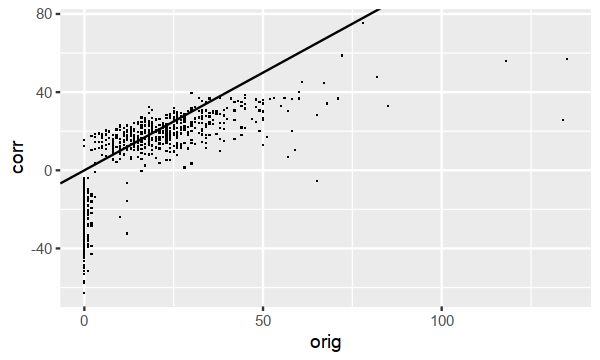

In [238]:
fig.size(3, 5)
data.table(orig = Xd['CD3D', ], corr = x['CD3D', ]) %>% 
    ggplot(aes(orig, corr)) + 
        geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0)



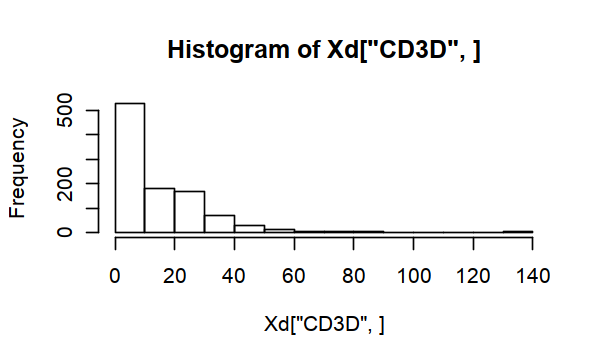

In [241]:
# hist(x['CD3D', ])
hist(Xd['CD3D', ])


# DEBUG: model params 

In [118]:
sourceCpp('utils.cpp')

In [200]:
## B x K
# x <- foo(Xd[1, , drop = FALSE], Phi, R, 1, c(0L, 1L))
x <- foo(Xd[1, , drop = FALSE], Phi, R, .01, c(0L))
Reduce(cbind, lapply(x, function(y) y[, 1]))

init,
0.0332,-0.6608
-0.0030,0.0863
0.0025,0.0061
-0.0025,0.0000
0.0000,-0.0061


In [203]:
# ?glmnet

In [199]:
Reduce(cbind, lapply(1:2, function(k) {
    x <- glmnet::glmnet(t(Phi)[, 2:5], 
                   as.numeric(log1p(Xd[1, ])), 
                   family = 'gaussian', 
                   intercept = TRUE, 
                   weights = R[k, ], alpha = 0, lambda = .01)
    
    data.frame(c(x$a0[1], x$beta[, 1]))
}))


,c.x.a0.1...x.beta...1..,c.x.a0.1...x.beta...1..
,<dbl>,<dbl>
s0,0.0293,-0.6393
depth,-0.0026,0.0837
dataset1,0.0024,0.0094
dataset2,-0.0023,0.0000
dataset3,0.0000,-0.0030


## Only depth

In [251]:
design <- model.matrix.full(c('depth'), meta_data)
head(design)

# sourceCpp('utils.cpp')

genes_use <- which(Matrix::rowSums(exprs_raw != 0) >= 100)
Xd <- as.matrix(exprs_raw[genes_use, ])
R <- t(model.matrix(~ 0 + cell_type, meta_data))
Phi <- t(design)

Intercept,depth
1,9.6
1,9.4
1,9.8
1,9.2
1,9.2
1,9.4


In [256]:
## B x K
x <- moe_gene(Xd, Phi, R, 1e6, c(0L, 1L))
row.names(x) <- row.names(Xd)
colnames(x) <- colnames(Xd)

# Debugging

# Generative models

What makes this whole thing challenging? 

    - multiple clusters
    - variance depends on mean 
    - depth as a covariate
    
What questions to ask? 

    - Poisson vs log-normal vs normal with mean=exp(.)
    - 

In [275]:
make_data <- function(samples1, samples2) {
    exprs <- cbind(samples1, samples2)
    meta_data <- data.frame(
        type = rep(c('A', 'B'), each = ncells),
        nUMI = colSums(exprs),
        nGene = colSums(exprs > 0)
    )
    meta_data$depth <- log(meta_data$nUMI)
    head(meta_data)

    R <- t(model.matrix(~ 0 + meta_data$type))
    row.names(R) <- c('A', 'B')

    colnames(exprs) <- paste0('X', seq_len(ncol(exprs)))
    row.names(exprs) <- paste0('G', seq_len(nrow(exprs)))    
    return(list(exprs = exprs, meta_data = meta_data))
}

## Case I

    1 cluster
    2 groups + batch effect
    no read depth correction
    same lambda for all genes
    

In [276]:
ngenes <- 10
ncells <- 100

samples1 <- matrix(rpois(ncells * ngenes, 10), nrow = ngenes)
samples2 <- matrix(rpois(ncells * ngenes, 12), nrow = ngenes)

x1 <- make_data(samples1, samples2)

In [278]:
# ## B x K
# x <- moe_gene(x1$exprs, Phi, R, 1e6, c(0L, 1L))
# row.names(x) <- row.names(Xd)
# colnames(x) <- colnames(Xd)

## Case II